In [1]:
%load_ext autoreload
%autoreload 2

import os
import time
import sys

sys.path.append(os.path.join(os.environ['REPO_DIR'], 'utilities'))
from utilities2015 import *
from metadata import *
from data_manager import *
from distributed_utilities import *

Setting environment for AWS compute node


No vtk
File does not exist: /shared/CSHL_data_processed/MD585/MD585_anchor.txt
File does not exist: /shared/CSHL_data_processed/MD585/MD585_sorted_filenames.txt
File does not exist: /shared/CSHL_data_processed/MD585/MD585_cropbox.txt
File does not exist: /shared/CSHL_data_processed/MD585/MD585_cropbox.txt
File does not exist: /shared/CSHL_data_processed/MD589/MD589_anchor.txt
File does not exist: /shared/CSHL_data_processed/MD589/MD589_sorted_filenames.txt
File does not exist: /shared/CSHL_data_processed/MD589/MD589_cropbox.txt
File does not exist: /shared/CSHL_data_processed/MD589/MD589_cropbox.txt
File does not exist: /shared/CSHL_data_processed/MD590/MD590_anchor.txt
File does not exist: /shared/CSHL_data_processed/MD590/MD590_sorted_filenames.txt
File does not exist: /shared/CSHL_data_processed/MD590/MD590_cropbox.txt
File does not exist: /shared/CSHL_data_processed/MD590/MD590_cropbox.txt
File does not exist: /shared/CSHL_data_processed/MD591/MD591_anchor.txt
File does not exist: 

In [84]:
stack = 'MD590'

In [85]:
tb_fmt = 'png'

In [86]:
transfer_data_synced(os.path.join('CSHL_data', stack), 
                     from_hostname='s3raw', to_hostname='ec2', is_dir=True, include_only='*.'+tb_fmt)

aws s3 cp --recursive s3://mousebrainatlas-rawdata/CSHL_data/MD590 /shared/CSHL_data/MD590 --exclude "*" --include "*.png"


Child returned 0


In [87]:
transfer_data_synced(os.path.join('CSHL_data_processed', stack, stack + '_sorted_filenames.txt'), 
                     from_hostname='s3', to_hostname='ec2', is_dir=False)

Child returned 0


rm -rf /shared/CSHL_data_processed/MD590/MD590_sorted_filenames.txt && mkdir -p /shared/CSHL_data_processed/MD590
aws s3 cp s3://mousebrainatlas-data/CSHL_data_processed/MD590/MD590_sorted_filenames.txt /shared/CSHL_data_processed/MD590/MD590_sorted_filenames.txt


Child returned 0


# Align

In [88]:
_, sections_to_filenames = DataManager.load_sorted_filenames(stack=stack)
valid_filenames = [fn for fn in sections_to_filenames.values() if not is_invalid(fn=fn)]

In [89]:
script = os.path.join(REPO_DIR, 'preprocess', 'align_consecutive_v2.py')
input_dir = os.path.join(RAW_DATA_DIR, stack)
output_dir = os.path.join(DATA_DIR, stack, stack + '_elastix_output')

In [8]:
rm -r $output_dir

rm: cannot remove '/shared/CSHL_data_processed/MD594/MD594_elastix_output': No such file or directory


In [9]:
t = time.time()
print 'Align...'

run_distributed("%(script)s %(stack)s %(input_dir)s %(output_dir)s \'%%(kwargs_str)s\' %(fmt)s" % \
                {'script': script,
                'stack': stack,
                'input_dir': input_dir,
                'output_dir': output_dir,
                'fmt': tb_fmt},
                kwargs_list=[{'prev_fn': valid_filenames[i-1], 'curr_fn': valid_filenames[i]} for i in range(1, len(valid_filenames))],
                argument_type='list',
               cluster_size=16,
                exclude_nodes=[33]) # 

print 'done in', time.time() - t, 'seconds' # 920 seconds

Align...
Setting autoscaling group cfncluster-yuncongCluster-ComputeFleet-7WGRSACDKZ5E capaticy to 16.
Wait for SGE to know all nodes...
All nodes are ready.
done in 916.468013048 seconds


qsub returned.


In [10]:
transfer_data_synced(os.path.join('CSHL_data_processed', stack, stack + '_elastix_output'), 
                     from_hostname='ec2', to_hostname='s3', is_dir=True)

aws s3 cp --recursive /shared/CSHL_data_processed/MD594/MD594_elastix_output s3://mousebrainatlas-data/CSHL_data_processed/MD594/MD594_elastix_output


Child returned 0


# Check final metrics

In [48]:
import re

final_metric = {}
for i in range(1, len(valid_filenames)):
    prev_fn = valid_filenames[i-1]
    curr_fn = valid_filenames[i]
    with open(os.path.join(output_dir, curr_fn + '_to_' + prev_fn, 'elastix.log'), 'r') as f:
        t = f.read()
        g = re.search("Final metric value  = (.*?)\n", t)
#         final_metric[(curr_fn, prev_fn)] = -float(g.groups()[0])
        final_metric[i] = -float(g.groups()[0])

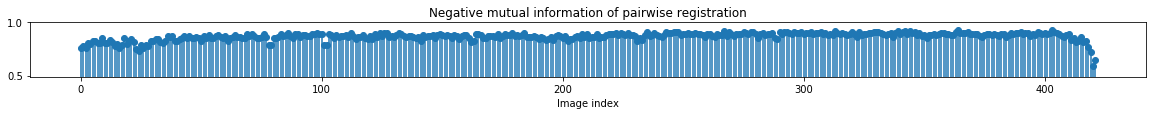

In [54]:
%matplotlib inline
metric_arr = np.array(final_metric.values())
plt.figure(figsize=(20,1));
plt.ylim([metric_arr.min()-.1, 1.]);
plt.stem(metric_arr);
plt.title('Negative mutual information of pairwise registration');
plt.xlabel('Image index');

In [51]:
print 'worst pair:', valid_filenames[np.argmin(final_metric.values())]

worst pair: MD594-IHC88-2015.08.26-20.45.05_MD594_3_0264


- download to local machine, edit consecutive transforms in local GUI, upload generated custom transforms to S3
- determine anchor image, upload the anchor filename file to S3.

# Compose

In [49]:
# transfer_data_synced(os.path.join('CSHL_data_processed', stack, stack + '_elastix_output'), 
#                      from_hostname='s3', to_hostname='ec2', is_dir=True)

In [10]:
transfer_data_synced(os.path.join('CSHL_data_processed', stack, stack + '_custom_transforms'), 
                     from_hostname='s3', to_hostname='ec2', is_dir=True)

rm -rf /shared/CSHL_data_processed/MD589/MD589_custom_transforms && mkdir -p /shared/CSHL_data_processed/MD589
aws s3 cp --recursive s3://mousebrainatlas-data/CSHL_data_processed/MD589/MD589_custom_transforms /shared/CSHL_data_processed/MD589/MD589_custom_transforms


Child returned 0
Child returned 0


In [57]:
transfer_data_synced(os.path.join('CSHL_data_processed', stack, stack + '_anchor.txt'), 
                     from_hostname='s3', to_hostname='ec2', is_dir=False)

rm -rf /shared/CSHL_data_processed/MD594/MD594_anchor.txt && mkdir -p /shared/CSHL_data_processed/MD594
aws s3 cp s3://mousebrainatlas-data/CSHL_data_processed/MD594/MD594_anchor.txt /shared/CSHL_data_processed/MD594/MD594_anchor.txt


Child returned 0
Child returned 0


In [58]:
anchor_fn = DataManager.load_anchor_filename(stack=stack)

In [59]:
script = os.path.join(REPO_DIR, 'preprocess', 'compose_transform_thumbnail_v2.py')
input_dir = os.path.join(DATA_DIR, stack, stack + '_elastix_output')
output_fn = os.path.join(DATA_DIR, stack, '%(stack)s_transformsTo_%(anchor_fn)s.pkl' % \
                                                dict(stack=stack, anchor_fn=anchor_fn))

In [60]:
! rm -f $output_fn

In [61]:
t = time.time()
print 'Composing transform...'

run_distributed("%(script)s %(stack)s %(input_dir)s \'%%(kwargs_str)s\' %(anchor_idx)d %(output_fn)s" % \
            {'stack': stack,
            'script': script
            'input_dir': input_dir,
            'anchor_idx': valid_filenames.index(anchor_fn),
            'output_fn': output_fn},
            kwargs_list=[{'filenames': valid_filenames}],
            argument_type='list',
               cluster_size=1,
               exclude_nodes=[33])

linked_name = os.path.join(DATA_DIR, stack, '%(stack)s_transformsTo_anchor.pkl' % dict(stack=stack))
execute_command('rm -f ' + linked_name)
execute_command('ln -s ' + output_fn + ' ' + linked_name)

print 'done in', time.time() - t, 'seconds'

Composing transform...
rm -f /shared/CSHL_data_processed/MD594/MD594_transformsTo_anchor.pkl
ln -s /shared/CSHL_data_processed/MD594/MD594_transformsTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172.pkl /shared/CSHL_data_processed/MD594/MD594_transformsTo_anchor.pkl
done in 15.182505846 seconds


qsub returned.
Child returned 0
Child returned 0


In [62]:
transfer_data_synced(os.path.join('CSHL_data_processed', stack), 
                     from_hostname='ec2', to_hostname='s3', is_dir=True, include_only='*.pkl')

aws s3 cp --recursive /shared/CSHL_data_processed/MD594 s3://mousebrainatlas-data/CSHL_data_processed/MD594 --exclude "*" --include "*.pkl"


Child returned 0


In [36]:
# transfer_data_synced(os.path.join('CSHL_data_processed', stack), 
#                      from_hostname='ec2', to_hostname='s3', is_dir=True, include_only='*.pkl')

In [84]:
# transfer_data_synced(os.path.join('CSHL_data_processed', stack, stack + '_elastix_output'), 
#                      from_hostname='ec2', to_hostname='s3', is_dir=True)

# Warp

In [ ]:
transfer_data_synced(os.path.join('CSHL_data_processed', stack), 
                     from_hostname='s3', to_hostname='ec2', is_dir=True, include_only='*.pkl')

In [63]:
if stack in all_nissl_stacks:
    pad_bg_color = 'white'
else:
    pad_bg_color = 'auto'

In [64]:
input_dir = os.path.join(RAW_DATA_DIR, stack)
out_dir = os.path.join(DATA_DIR, stack, stack + '_thumbnail_alignedTo_' + anchor_fn)
script = os.path.join(REPO_DIR, 'preprocess', 'warp_crop_IM_v2.py')

In [65]:
! rm -rf $out_dir

In [66]:
t = time.time()
print 'Warping...'

transforms_filename = os.path.join(DATA_DIR, stack, '%(stack)s_transformsTo_%(anchor_fn)s.pkl' % \
                                   dict(stack=stack, anchor_fn=anchor_fn))
transforms_to_anchor = pickle.load(open(transforms_filename, 'r'))

if pad_bg_color == 'auto':
    run_distributed('%(script)s %(stack)s %(input_dir)s %(out_dir)s %%(transform)s %%(filename)s %%(output_fn)s thumbnail 0 0 2000 1500 %%(pad_bg_color)s' % \
                    {'script': script,
                    'stack': stack,
                    'input_dir': input_dir,
                    'out_dir': out_dir
                    },
                    kwargs_list=[{'transform': ','.join(map(str, transforms_to_anchor[fn].flatten())),
                                'filename': fn + '.' + tb_fmt,
                                'output_fn': fn + '_thumbnail_alignedTo_' + anchor_fn + '.tif',
                                'pad_bg_color': 'black' if fn.split('-')[1][0] == 'F' else 'white'}
                                for fn in valid_filenames],
                    exclude_nodes=[33],
                    argument_type='single',
                   cluster_size=16)
else:
    run_distributed('%(script)s %(stack)s %(input_dir)s %(out_dir)s %%(transform)s %%(filename)s %%(output_fn)s thumbnail 0 0 2000 1500 %(pad_bg_color)s' % \
                    {'script': script,
                    'stack': stack,
                    'input_dir': input_dir,
                    'out_dir': out_dir,
                    'pad_bg_color': pad_bg_color},
                    kwargs_list=[{'transform': ','.join(map(str, transforms_to_anchor[fn].flatten())),
                                'filename': fn + '.' + tb_fmt,
                                'output_fn': fn + '_thumbnail_alignedTo_' + anchor_fn + '.tif'}
                                for fn in valid_filenames],
                    exclude_nodes=[33],
                    argument_type='single',
                   cluster_size=16)

print 'done in', time.time() - t, 'seconds'

Warping...
Setting autoscaling group cfncluster-yuncongCluster-ComputeFleet-7WGRSACDKZ5E capaticy to 16.
Wait for SGE to know all nodes...
All nodes are ready.
done in 509.318166971 seconds


qsub returned.


In [67]:
transfer_data_synced(os.path.join('CSHL_data_processed', stack, stack + '_thumbnail_alignedTo_' + anchor_fn),
                    from_hostname='ec2',
                    to_hostname='s3',
                    is_dir=True)

aws s3 cp --recursive /shared/CSHL_data_processed/MD594/MD594_thumbnail_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172 s3://mousebrainatlas-data/CSHL_data_processed/MD594/MD594_thumbnail_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172


Child returned 0


- Go to local GUI, download aligned images to check correctness
- Place cropbox.

# Crop

In [68]:
transfer_data_synced(os.path.join('CSHL_data_processed', stack, stack + '_cropbox.txt'), 
                     from_hostname='s3', to_hostname='ec2', is_dir=False)

rm -rf /shared/CSHL_data_processed/MD594/MD594_cropbox.txt && mkdir -p /shared/CSHL_data_processed/MD594
aws s3 cp s3://mousebrainatlas-data/CSHL_data_processed/MD594/MD594_cropbox.txt /shared/CSHL_data_processed/MD594/MD594_cropbox.txt


Child returned 0
Child returned 0


In [69]:
xmin, xmax, ymin, ymax, first_sec, last_sec = DataManager.load_cropbox(stack=stack)
w = xmax + 1 - xmin
h = ymax + 1 - ymin
x = xmin
y = ymin

In [70]:
first_fn = sections_to_filenames[first_sec]
last_fn = sections_to_filenames[last_sec]

In [71]:
first_idx_among_valid = valid_filenames.index(first_fn)
last_idx_among_valid = valid_filenames.index(last_fn)

# Crop Thumbnail

In [ ]:
transfer_data_synced(os.path.join('CSHL_data_processed', stack, stack + '_thumbnail_alignedTo_' + anchor_fn),
                    from_hostname='s3',
                    to_hostname='ec2',
                    is_dir=True)

In [72]:
input_dir = os.path.join(DATA_DIR, stack, "%(stack)s_thumbnail_alignedTo_%(anchor_fn)s" % \
                           {'stack': stack, 'anchor_fn': anchor_fn})

output_dir = os.path.join(DATA_DIR, stack, "%(stack)s_thumbnail_alignedTo_%(anchor_fn)s_cropped" % \
                           {'stack': stack, 'anchor_fn': anchor_fn})

execute_command('mkdir -p ' + output_dir)

mkdir -p /shared/CSHL_data_processed/MD594/MD594_thumbnail_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped


Child returned 0


0

In [73]:
t = time.time()
sys.stderr.write('cropping thumbnail...')

execute_command('mogrify -set filename:name %%t -crop %(w)dx%(h)d+%(x)d+%(y)d -write "%(output_dir)s/%%[filename:name]_cropped.tif" %(input_dir)s/*.tif' % \
    {'input_dir': input_dir,
     'output_dir': output_dir,
    'w':w, 'h':h, 'x':x, 'y':y})

sys.stderr.write('done in %f seconds\n' % (time.time() - t)) # 100 seconds

cropping thumbnail...

mogrify -set filename:name %t -crop 538x347+618+89 -write "/shared/CSHL_data_processed/MD594/MD594_thumbnail_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/%[filename:name]_cropped.tif" /shared/CSHL_data_processed/MD594/MD594_thumbnail_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172/*.tif


Child returned 0
done in 26.811117 seconds


In [74]:
transfer_data_synced(os.path.join('CSHL_data_processed', stack, stack + '_thumbnail_alignedTo_' + anchor_fn + '_cropped'),
                    from_hostname='ec2',
                    to_hostname='s3',
                    is_dir=True)

aws s3 cp --recursive /shared/CSHL_data_processed/MD594/MD594_thumbnail_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped s3://mousebrainatlas-data/CSHL_data_processed/MD594/MD594_thumbnail_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped


Child returned 0


# Expand lossless JP2

In [29]:
transfer_data_synced(os.path.join('CSHL_data', stack),
                    from_hostname='s3raw',
                    to_hostname='ec2',
                    is_dir=True,
                    include_only='*_lossless.jp2')

aws s3 cp --recursive s3://mousebrainatlas-rawdata/CSHL_data/MD589 /shared/CSHL_data/MD589 --exclude "*" --include "*_lossless.jp2"


Child returned 0


In [ ]:
t = time.time()
sys.stderr.write('expanding...')

output_dir = create_if_not_exists(os.path.join(DATA_DIR, stack, stack + '_lossless_tif'))
input_dir = os.path.join(RAW_DATA_DIR, stack)

# filenames_to_expand = [fn for fn in filenames[first_idx:last_idx+1] if not os.path.exists(os.path.join(input_dir, fn + '_lossless.tif'))]

filenames_to_expand = [fn for fn in valid_filenames[first_idx_among_valid:last_idx_among_valid+1] 
                       if not os.path.exists(os.path.join(input_dir, fn + '_lossless.tif'))]

run_distributed('export LD_LIBRARY_PATH=/home/ubuntu/KDU79_Demo_Apps_for_Linux-x86-64_170108:$LD_LIBRARY_PATH; %(kdu_bin)s -i %(input_dir)s/%%(fn)s_lossless.jp2 -o %(output_dir)s/%%(fn)s_lossless.tif' % \
                {'kdu_bin': KDU_EXPAND_BIN,
                 'output_dir': output_dir,
                'input_dir': input_dir},
                kwargs_list={'fn': filenames_to_expand},
                exclude_nodes=[33],
                argument_type='single',
               cluster_size=16)

sys.stderr.write('done in %f seconds\n' % (time.time() - t)) # 900 seconds.

In [ ]:
transfer_data_synced(os.path.join('CSHL_data_processed', stack, stack + '_lossless_tif'),
                    from_hostname='ec2',
                    to_hostname='s3',
                    is_dir=True)

aws s3 cp --recursive /shared/CSHL_data_processed/MD657/MD657_lossless_tif s3://mousebrainatlas-data/CSHL_data_processed/MD657/MD657_lossless_tif


# Warping and cropping lossless

In [75]:
transfer_data_synced(os.path.join('CSHL_data_processed', stack, stack + '_lossless_tif'),
                    from_hostname='s3',
                    to_hostname='ec2',
                    is_dir=True)

rm -rf /shared/CSHL_data_processed/MD594/MD594_lossless_tif && mkdir -p /shared/CSHL_data_processed/MD594
aws s3 cp --recursive s3://mousebrainatlas-data/CSHL_data_processed/MD594/MD594_lossless_tif /shared/CSHL_data_processed/MD594/MD594_lossless_tif


Child returned 0
Child returned 0


In [76]:
tf_filepath = os.path.join(DATA_DIR, stack, '%(stack)s_transformsTo_anchor.pkl' % {'stack':stack})
tfs = pickle.load(open(tf_filepath, 'r'))
# Note that the index from trasform pickle file starts at 0, BUT the .._renamed folder index starts at 1.#

lossless_tif_dir = os.path.join(DATA_DIR, stack, stack + '_lossless_tif')
lossless_aligned_cropped_dir = os.path.join(DATA_DIR, stack, stack + '_lossless_alignedTo_' + anchor_fn + '_cropped')

script_fp = os.path.join(REPO_DIR, 'preprocess', 'warp_crop_IM_v2.py')

In [77]:
rm -r $lossless_aligned_cropped_dir

rm: cannot remove '/shared/CSHL_data_processed/MD594/MD594_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped': No such file or directory


In [78]:
if stack in all_nissl_stacks:
    pad_bg_color = 'white'
else:
    pad_bg_color = 'auto'

In [79]:
t = time.time()
sys.stderr.write('warping and cropping lossless...')
                   
if pad_bg_color == 'auto':
    # If alternating, then black padding for F sections, white padding for N sections.
    run_distributed(command='%(script_path)s %(stack)s %(lossless_tif_dir)s %(lossless_aligned_cropped_dir)s %%(transform)s %%(filename)s %%(output_fn)s lossless %(x)d %(y)d %(w)d %(h)d %%(pad_bg_color)s'%\
                    {'script_path': script_fp,
                    'stack': stack,
                    'lossless_tif_dir': lossless_tif_dir,
                    'lossless_aligned_cropped_dir': lossless_aligned_cropped_dir,
                    'x': x,
                    'y': y,
                    'w': w,
                    'h': h},
                    kwargs_list=[{'transform': ','.join(map(str, tfs[fn].flatten())),
                                'filename': fn + '_lossless.tif',
                                'output_fn': fn + '_lossless_alignedTo_' + anchor_fn + '_cropped.tif',
                                'pad_bg_color': 'black' if fn.split('-')[1][0] == 'F' else 'white'}
                                for fn in valid_filenames[first_idx_among_valid:last_idx_among_valid+1]],
                    exclude_nodes=[33],
                    argument_type='single',
                   cluster_size=16)
else:
    run_distributed(command='%(script_path)s %(stack)s %(lossless_tif_dir)s %(lossless_aligned_cropped_dir)s %%(transform)s %%(filename)s %%(output_fn)s lossless %(x)d %(y)d %(w)d %(h)d %(pad_bg_color)s'%\
                    {'script_path': script_fp,
                    'stack': stack,
                    'lossless_tif_dir': lossless_tif_dir,
                    'lossless_aligned_cropped_dir': lossless_aligned_cropped_dir,
                    'x': x,
                    'y': y,
                    'w': w,
                    'h': h,
                    'pad_bg_color': pad_bg_color},
                    kwargs_list=[{'transform': ','.join(map(str, tfs[fn].flatten())),
                                'filename': fn + '_lossless.tif',
                                'output_fn': fn + '_lossless_alignedTo_' + anchor_fn + '_cropped.tif'}
                                for fn in valid_filenames[first_idx_among_valid:last_idx_among_valid+1]],
                    exclude_nodes=[33],
                    argument_type='single',
                   cluster_size=16)

sys.stderr.write('done in %f seconds\n' % (time.time() - t)) # 500 seconds. 5000s(AWS)

warping and cropping lossless...

Setting autoscaling group cfncluster-yuncongCluster-ComputeFleet-7WGRSACDKZ5E capaticy to 16.
Wait for SGE to know all nodes...
All nodes are ready.


qsub returned.
done in 4874.720928 seconds


In [80]:
transfer_data_synced(os.path.join('CSHL_data_processed', stack, stack + '_lossless_alignedTo_' + anchor_fn + '_cropped'),
                    from_hostname='ec2',
                    to_hostname='s3',
                    is_dir=True)

aws s3 cp --recursive /shared/CSHL_data_processed/MD594/MD594_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped s3://mousebrainatlas-data/CSHL_data_processed/MD594/MD594_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped


Child returned 0


# (optional) contrast stretch Neurotrace images

In [141]:
script_fp = os.path.join(REPO_DIR, 'preprocess', 'stretch_contrast_neurotrace.py')
# in_dir = os.path.join(DATA_DIR, stack, stack + '_lossless_tif')
# out_dir = os.path.join(DATA_DIR, stack, stack + '_lossless_tif_contrast_stretched')
in_dir = os.path.join(DATA_DIR, stack, stack + '_lossless_alignedTo_' + anchor_fn + '_cropped')
out_dir = os.path.join(DATA_DIR, stack, stack + '_lossless_alignedTo_' + anchor_fn + '_cropped_contrast_stretched')

In [142]:
! mkdir -p $out_dir

In [145]:
t = time.time()
sys.stderr.write('Contrast stretch neurotrace images...')
               
run_distributed(command='%(script_path)s %%(in_fn)s %%(out_fn)s %(imin)d %(imax)d'%\
                    {'script_path': script_fp,
                     'imin': 0,
                     'imax': 400
                    },
                    kwargs_list=[{'in_fn': os.path.join(in_dir, fn + '_lossless_alignedTo_' + anchor_fn + '_cropped.tif'),
                                'out_fn': os.path.join(out_dir, fn + '_lossless_alignedTo_' + anchor_fn + '_cropped_contrast_stretched.tif')}
                                for fn in valid_filenames[first_idx_among_valid:last_idx_among_valid+1]
                                if fn.split('-')[1][0] == 'F'],
                    exclude_nodes=[33],
                    argument_type='single',
                   cluster_size=16)

sys.stderr.write('done in %f seconds\n' % (time.time() - t)) # 2500 seconds

Contrast stretch neurotrace images...

Setting autoscaling group cfncluster-yuncongCluster-ComputeFleet-P6LX3QPGCISG capaticy to 16.
Wait for SGE to know all nodes...
All nodes are ready.


qsub returned.
done in 2443.298327 seconds


In [9]:
transfer_data_synced(os.path.join('CSHL_data_processed', stack, stack + '_lossless_alignedTo_' + anchor_fn + '_cropped_contrast_stretched'),
                    from_hostname='ec2',
                    to_hostname='s3',
                    is_dir=True)

aws s3 cp --recursive /shared/CSHL_data_processed/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_contrast_stretched s3://mousebrainatlas-data/CSHL_data_processed/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_contrast_stretched


Child returned 0


# Generate JPEG

In [18]:
transfer_data_synced(os.path.join('CSHL_data_processed', stack, stack + '_lossless_alignedTo_' + anchor_fn + '_cropped'),
                    from_hostname='s3',
                    to_hostname='ec2',
                    is_dir=True)

rm -rf /shared/CSHL_data_processed/MD589/MD589_lossless_alignedTo_MD589-IHC31-2015.07.30-23.26.22_MD589_1_0091_cropped && mkdir -p /shared/CSHL_data_processed/MD589
aws s3 cp --recursive s3://mousebrainatlas-data/CSHL_data_processed/MD589/MD589_lossless_alignedTo_MD589-IHC31-2015.07.30-23.26.22_MD589_1_0091_cropped /shared/CSHL_data_processed/MD589/MD589_lossless_alignedTo_MD589-IHC31-2015.07.30-23.26.22_MD589_1_0091_cropped


Child returned 0
Child returned 0


In [81]:
script_fp = os.path.join(REPO_DIR, 'preprocess', 'generate_other_versions_v2.py')
input_dir = os.path.join(DATA_DIR, stack, stack + '_lossless_alignedTo_' + anchor_fn + '_cropped')
out_jpeg_dir = os.path.join(DATA_DIR, stack, stack + '_lossless_alignedTo_' + anchor_fn + '_cropped_compressed')

In [82]:
t = time.time()
print 'Generating compressed image...',

if stack in all_nissl_stacks:
    
    run_distributed('%(script)s %(stack)s %(input_dir)s \'%%(input_filenames)s\' --output_compressed_dir %(output_compressed_dir)s' % \
                dict(script=script_fp,
                     stack=stack,
                     input_dir=input_dir,
                     output_compressed_dir=out_jpeg_dir),
                    kwargs_list={'input_filenames': 
                                 [fn + '_lossless_alignedTo_' + anchor_fn + '_cropped.tif' 
                                  for fn in valid_filenames[first_idx_among_valid:last_idx_among_valid+1]]},
                    exclude_nodes=[33],
                    argument_type='list2',
                    cluster_size=16)
    
else:
    run_distributed('%(script)s %(stack)s %(input_dir)s \'%%(input_filenames)s\' --output_compressed_dir %(output_compressed_dir)s' % \
                    dict(script=script_fp,
                         stack=stack,
                         input_dir=input_dir,
                         output_compressed_dir=out_jpeg_dir),
                        kwargs_list={'input_filenames': 
                                     [fn + '_lossless_alignedTo_' + anchor_fn + '_cropped.tif' 
                                      for fn in valid_filenames[first_idx_among_valid:last_idx_among_valid+1] 
                                      if fn.split('-')[1].startswith('N')]},
                        exclude_nodes=[33],
                        argument_type='list2',
                        cluster_size=16)
                
print 'done in', time.time() - t, 'seconds' # 900 seconds.

Generating compressed image... Setting autoscaling group cfncluster-yuncongCluster-ComputeFleet-7WGRSACDKZ5E capaticy to 16.
Wait for SGE to know all nodes...
All nodes are ready.
done in 765.184411049 seconds


qsub returned.


In [83]:
transfer_data_synced(os.path.join('CSHL_data_processed', stack, stack + '_lossless_alignedTo_' + anchor_fn + '_cropped_compressed'),
                    from_hostname='ec2',
                    to_hostname='s3',
                    is_dir=True)

aws s3 cp --recursive /shared/CSHL_data_processed/MD594/MD594_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_compressed s3://mousebrainatlas-data/CSHL_data_processed/MD594/MD594_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_compressed


Child returned 0


# Generate JPEG for neurotrace

In [146]:
script_fp = os.path.join(REPO_DIR, 'preprocess', 'generate_other_versions_v2.py')
input_dir = os.path.join(DATA_DIR, stack, stack + '_lossless_alignedTo_' + anchor_fn + '_cropped_contrast_stretched')
out_jpeg_dir = os.path.join(DATA_DIR, stack, stack + '_lossless_alignedTo_' + anchor_fn + '_cropped_compressed')

In [147]:
t = time.time()
print 'Generating compressed image...',

run_distributed('%(script)s %(stack)s %(input_dir)s \'%%(input_filenames)s\' --output_compressed_dir %(output_compressed_dir)s' % \
                dict(script=script_fp,
                     stack=stack,
                     input_dir=input_dir,
                     output_compressed_dir=out_jpeg_dir),
                    kwargs_list={'input_filenames': 
                                 [fn + '_lossless_alignedTo_' + anchor_fn + '_cropped_contrast_stretched.tif' 
                                  for fn in valid_filenames[first_idx_among_valid:last_idx_among_valid+1] 
                                  if fn.split('-')[1].startswith('F')]},
                    exclude_nodes=[33],
                    argument_type='list2',
                    cluster_size=16)
                
print 'done in', time.time() - t, 'seconds'

Generating compressed image... Setting autoscaling group cfncluster-yuncongCluster-ComputeFleet-P6LX3QPGCISG capaticy to 16.
Wait for SGE to know all nodes...
All nodes are ready.
done in 1520.75712705 seconds


qsub returned.


In [148]:
transfer_data_synced(os.path.join('CSHL_data_processed', stack, stack + '_lossless_alignedTo_' + anchor_fn + '_cropped_compressed'),
                    from_hostname='ec2',
                    to_hostname='s3',
                    is_dir=True,
                    include_only='*contrast_stretched*.jpg')

aws s3 cp --recursive /shared/CSHL_data_processed/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_compressed s3://mousebrainatlas-data/CSHL_data_processed/MD657/MD657_lossless_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped_compressed --exclude "*" --include "*contrast_stretched*.jpg"


Child returned 0


In [ ]:
# t = time.time()
# print 'Generating saturation image...',

# run_distributed4('%(script)s %(stack)s %(input_dir)s \'%%(input_filenames)s\' --output_saturation_dir %(output_saturation_dir)s' % \
#                 dict(script=script_fp,
#                      stack=stack,
#                      input_dir=input_dir,
#                      output_saturation_dir=out_sat_dir,
#                      kwargs_list={'input_filenames': [fn + '_lossless_alignedTo_' + anchor_fn + '_cropped.tif' for fn in filenames[first_idx:last_idx+1]]},
#                     exclude_nodes=exclude_nodes,
#                     argument_type='list2')

# print 'done in', time.time() - t, 'seconds'

# Generate Masks

In [4]:
from preprocess_utilities import *

In [5]:
input_dir = os.path.join(RAW_DATA_DIR, stack)
output_dir = create_if_not_exists(os.path.join(DATA_DIR, stack, stack + '_submasks'))

In [6]:
border_dissim_percentile = DEFAULT_BORDER_DISSIMILARITY_PERCENTILE
min_size = DEFAULT_MINSIZE

In [7]:
t = time.time()
print 'Generating thumbnail mask...',

# !! For some reason (perhaps too much simultaneous write to disk), the distributed computation cannot finish, usually stuck with only a few sections left.
script = os.path.join(os.environ['REPO_DIR'], 'preprocess', 'generate_thumbnail_masks_v4.py')

run_distributed(command='%(script_path)s %(stack)s %(input_dir)s \'%%(filenames)s\' %(output_dir)s --border_dissim_percentile %(border_dissim_percentile)d --min_size %(min_size)d' % \
                {'script_path': script,
                'stack': stack,
                'input_dir': input_dir,
                'output_dir': output_dir,
                'border_dissim_percentile': border_dissim_percentile,
                'min_size': min_size},
                kwargs_list=dict(filenames=filenames),
                exclude_nodes=[33],
                argument_type='list2')

print 'done in', time.time() - t, 'seconds' # 1600s

Generating thumbnail mask... ['gcn-20-33.sdsc.edu'] are excluded
Using nodes: ['gcn-20-31.sdsc.edu', 'gcn-20-32.sdsc.edu', 'gcn-20-34.sdsc.edu', 'gcn-20-35.sdsc.edu', 'gcn-20-36.sdsc.edu', 'gcn-20-37.sdsc.edu', 'gcn-20-38.sdsc.edu', 'gcn-20-41.sdsc.edu', 'gcn-20-42.sdsc.edu', 'gcn-20-43.sdsc.edu', 'gcn-20-44.sdsc.edu', 'gcn-20-45.sdsc.edu', 'gcn-20-46.sdsc.edu', 'gcn-20-47.sdsc.edu', 'gcn-20-48.sdsc.edu']
done in 551.316730022 seconds


In [ ]:
# ... Review in local machine using GUI...

# Warp Thumbnail Masks

In [11]:
script = os.path.join(os.environ['REPO_DIR'], 'preprocess', 'warp_crop_IM_v2.py')
input_dir = os.path.join(DATA_DIR, stack, stack + '_masks')
output_dir = os.path.join(DATA_DIR, stack, stack + '_masks_alignedTo_' + anchor_fn)

execute_command('rm -rf ' + output_dir)

transforms_filename = os.path.join(DATA_DIR, stack, stack+'_elastix_output', 
                                   '%(stack)s_transformsTo_%(anchor_fn)s.pkl' % \
                                   dict(stack=stack, anchor_fn=anchor_fn))
transforms_to_anchor = pickle.load(open(transforms_filename, 'r'))

rm -rf /oasis/projects/nsf/csd395/yuncong/CSHL_data_processed/MD657/MD657_masks_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130


Child returned 0


In [12]:
t = time.time()
print 'warping thumbnail mask...',

run_distributed4('%(script)s %(stack)s %(input_dir)s %(output_dir)s %%(transform)s %%(filename)s %%(output_fn)s thumbnail 0 0 2000 1500 black' % \
                {'script': script,
                'stack': stack,
                'input_dir': input_dir,
                'output_dir': output_dir},
                kwargs_list=[{'transform': ','.join(map(str, transforms_to_anchor[fn].flatten())),
                            'filename': fn + '_mask.png',
                            'output_fn': fn + '_mask_alignedTo_' + anchor_fn + '.png'}
                            for fn in filenames],
                exclude_nodes=[33],
                argument_type='single')

print 'done in', time.time() - t, 'seconds' # 780

warping thumbnail mask... ['gcn-20-33.sdsc.edu'] are excluded
Using nodes: ['gcn-20-31.sdsc.edu', 'gcn-20-32.sdsc.edu', 'gcn-20-34.sdsc.edu', 'gcn-20-35.sdsc.edu', 'gcn-20-36.sdsc.edu', 'gcn-20-37.sdsc.edu', 'gcn-20-38.sdsc.edu', 'gcn-20-41.sdsc.edu', 'gcn-20-42.sdsc.edu', 'gcn-20-43.sdsc.edu', 'gcn-20-44.sdsc.edu', 'gcn-20-45.sdsc.edu', 'gcn-20-46.sdsc.edu', 'gcn-20-47.sdsc.edu', 'gcn-20-48.sdsc.edu']
done in 780.778076887 seconds


# Crop Thumbnail Masks

In [13]:
input_dir = os.path.join(DATA_DIR, stack, stack + '_masks_alignedTo_' + anchor_fn)
output_dir = os.path.join(DATA_DIR, stack, stack + '_masks_alignedTo_' + anchor_fn + '_cropped')

execute_command('rm -rf ' + output_dir)
execute_command('mkdir -p ' + output_dir)

rm -rf /oasis/projects/nsf/csd395/yuncong/CSHL_data_processed/MD657/MD657_masks_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped
mkdir -p /oasis/projects/nsf/csd395/yuncong/CSHL_data_processed/MD657/MD657_masks_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped


Child returned 0
Child returned 0


0

In [14]:
t = time.time()
sys.stderr.write('cropping thumbnail mask...')

execute_command('mogrify -set filename:name %%t -crop %(w)dx%(h)d+%(x)d+%(y)d -write "%(output_dir)s/%%[filename:name]_cropped.png" %(input_dir)s/*.png' % \
    {'stack': stack,
    'input_dir': input_dir,
    'output_dir': output_dir,
    'w':xmax+1-xmin, 'h':ymax+1-ymin, 'x':xmin, 'y':ymin})

sys.stderr.write('done in %f seconds\n' % (time.time() - t)) # 70s

cropping thumbnail mask...

mogrify -set filename:name %t -crop 862x530+774+247 -write "/oasis/projects/nsf/csd395/yuncong/CSHL_data_processed/MD657/MD657_masks_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130_cropped/%[filename:name]_cropped.png" /oasis/projects/nsf/csd395/yuncong/CSHL_data_processed/MD657/MD657_masks_alignedTo_MD657-F44-2017.02.18-06.06.27_MD657_1_0130/*.png


Child returned 0
done in 73.238121 seconds


In [48]:
! tail /home/ubuntu/stderr_0.log

Child returned 0
Child returned 0
Child returned 0
Child returned 0
Child returned 0
Child returned 0
Traceback (most recent call last):
  File "/shared/MouseBrainAtlas/preprocess/compose_transform_thumbnail_v2.py", line 95, in <module>
    T_composed = np.dot(np.linalg.inv(transformation_to_previous_sec[i]), T_composed)
KeyError: 208
